WELCOME TO EMPhASIS CALIBRATION SYSTEM!
Calibration phase is mandatory before the first usage on a new user of EMPhASIS system.
At the end of this process you will be provided of the threshold and the PCA weights to properly tune your overlay.

In [ ]:
############################################################################
#                                    Libraries                             #
############################################################################
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import scipy.fftpack
from scipy.signal import lombscargle
from scipy import signal
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

Once the necessary libraries are imported, you need to upload your ECG recording in a .csv format.
The recording must be at least 5 minutes long and must contain observations both related to a relaxed and a stressful conditions.
Please upload your recording in the same Jupyter folder of the notebook and substitute the name 118e06.csv with your own file.
Please also check the structure of your recording and change the df.columns accordling to that.
Then drop all the columns, exception for the one containing your ECG values.

In [89]:
############################################################################
#                                Values Acquisition                        #
############################################################################
def calibration_sample_acquisition():
#In this calibration example we use the rec 118e06, retrived from the MIT-BIH
#Noise Stress Test Database.
#Please notice that the recording must be at least 5 minutes long and that
#it must be recordered both in relaxed and stressed conditions.
    with open('118e06.csv') as csvfile:
        df = pd.read_fwf(csvfile)

    df.columns = ["ID", "NOISE", "FILTERED"]

    #Keep just the clean series 
    df = df.drop(["NOISE"], axis=1)
    df = df.drop(["ID"], axis=1)
    df.columns = ["ECG"]
    
    return df

In [76]:
############################################################################
#                               PCA Weights Computation                    #
############################################################################
def calibration_pca_weigths(df):
#This function takes in input the whole offline recording and returns as an
#output the PCA weights

    #Peaks detection
    window = 2 
    SCAN = 40000
    beats = []
    
    for i in range(0, len(df["ECG"]), SCAN):
        df_filt = df.iloc[i:i+SCAN]
        ecg = df_filt["ECG"]
        filt_ecg = ecg - ecg.mean()
        beats.extend(filt_ecg)
        
    df['FILTERED'] = beats
    avg_ecg = df['FILTERED'].rolling(int(window)).mean() #Calculate moving average

    #Increase the peaks value of 20% to prevent recognition of the 
    #secondary heart contraction from interferring
    avg_ecg = [x*1.2 for x in avg_ecg] 
    df['ROLLING_MEAN'] = avg_ecg 

    #Mark regions of interest
    window = []
    peaklist = []
    listpos = 0 
    maximum = 0
    for datapoint in beats:
        rollingmean = avg_ecg[listpos] #Get local mean
        if (datapoint > rollingmean): 
            #If samples value is greater than local mean, the ROI is found
            window.append(datapoint)
        elif(len(window) > 1): 
            #Notate the position of the point on the X-axis
            beatposition = listpos - len(window) + (window.index(max(window))) 
            #Add detected peak to list
            start = listpos - len(window)
            if(beats[beatposition]>150):
                peaklist.append(beatposition)
                window = [] #Clear marked ROI
        listpos = listpos + 1
        
    #Create a new df with rr and hr
    rr = []
    for i in range (0, len(peaklist)-1,1):
        if(peaklist[i+1]-peaklist[i]>100):
            rri = (peaklist[i+1]-peaklist[i])
            rr.append(rri)
            
    df = pd.DataFrame(rr)
    df.columns = ["RR"]
    df["HR"] = (60/df["RR"].div(1000))
    df = df.reset_index()

    #Time domain features
    mRR = []
    mHR = []

    #Frequency domain features
    nLF = []
    nHF = []
    dLFHF  = []
    SVI = []

    #Define frequency ranges for very low, low and high bands
    vlf_band=(0, 0.04)
    lf_band=(0.04, 0.15) 
    hf_band=(0.15, 0.4)

    #Rolling window of 10 samples to compute each new feature
    spectra = []
    for start in range(0, len(df["RR"])-16, 1):
        end = start + 16
        work_df = df.iloc[start:end]
        #mRR 
        mrr = work_df["RR"].mean()
        mRR.append(mrr)
        #mHR
        mhr = work_df["HR"].mean()
        mHR.append(mhr)

        #Fourier Transform
        #To calculate the spectrum mean must be removed from the signal
        rr_work = work_df["RR"] - work_df["RR"].mean()
        Ts = len(rr_work) 
        fxx = np.linspace(0, 0.5, Ts/2)
        pxx = scipy.fftpack.fft(rr_work)
        pxx = (pxx[range((int)(Ts/2))])

        for i in range(0,len(pxx)):
            pxx[i] = ((pxx[i].real*pxx[i].real + pxx[i].imag*pxx[i].imag))
        spectra.extend(pxx.real)

        #Frequency content estraction
        lf_indexes = np.logical_and(fxx >= lf_band[0], fxx < lf_band[1])
        hf_indexes = np.logical_and(fxx >= hf_band[0], fxx < hf_band[1])
        lf = (float)(np.trapz(y=(pxx.real[lf_indexes]), x=fxx[lf_indexes]))
        hf = (float)(np.trapz(y=(pxx.real[hf_indexes]), x=fxx[hf_indexes]))

        #SVI
        lf_hf = lf/hf 
        SVI.append(lf_hf)
        #nLF and nHF
        # Percentage of sympatetic and parasympathetic activity not considering 
        # vlf, which in short recordings usually contains noise. 
        lfnu = (lf / (lf+hf)) * 100 
        hfnu = (hf / (lf+hf)) * 100 
        nLF.append(lfnu)
        nHF.append(hfnu)
        #dLFHF
        dlfhf = np.abs(lfnu-hfnu)
        dLFHF.append(dlfhf)

    data = {'mRR': mRR, 'mHR': mHR,
    'SVI': SVI, 'nLF': nLF, 'nHF': nHF, 'dLFHF': dLFHF}
    df = pd.DataFrame(data=data)

    pca = PCA(n_components=2).fit(df)
    pca_d = pca.transform(df)
    
    weights = pca.components_
    return weights, pca_d, df
    

In [91]:
############################################################################
#                             Threshold Calibration                        #
############################################################################
def get_threshold(weights, pca_d, df):
#This function takes an an input the PCA weights and the DataFrame expressed
#both in PCA and features space ad returns the most suitable threshold to
#tune the classifier.

    model = KMeans(n_clusters=2)
    kmeansoutput = model.fit(pca_d)
    
    #Plot of the two clusters identified by the classifier
    plt.figure()
    plt.title("KMeans Clusters")
    plt.scatter(pca_d[:, 0], pca_d[:, 1], c=kmeansoutput.labels_)
    plt.show()

    #Threshold tuning
    tp_prec = 0
    tn_prec = 0
    thres = 0
    for t in range(200,600):
        predicted = []
        for index, row in df.iterrows():
            val = (row['SVI']*(weights[0][0]) + row['dLFHF']*(weights[0][1]) + 
            row['mHR']*(weights[0][2]) + row['mRR']*(weights[0][3]) + 
            row['nHF']*(weights[0][4]) + row['nLF']*(weights[0][5]))
            if(val>t):
                predicted.append(1)
            else:
                predicted.append(0)

        #Confusion matrix
        tn, fp, fn, tp = confusion_matrix(kmeansoutput.labels_, predicted).ravel()
        summ = tp + tn
        prec = tp_prec + tn_prec
        #If the accuracy improves with the new threshold, update the thres
        if(summ>prec):
            thres = t
            results = predicted
        tp_prec = tp
        tn_prec = tn
        
    return thres, results

Once you run all the previously cells, run the main function.
You will se displayed the PCA weights and the threshold to insert in the HLS classifier.cpp function.

Welcome to the calibration phase of EMPhASIS.
Please, remember that calibration is necessary just once, before the first utilizaiton on a new subject.


-f:87: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


PCA weights you have to set in the config file are: 
A: 0.0013074218184062677
B: -0.004702030930856778
C: -0.06679528503791143
D: 0.9970866226210103
E: -0.025815096748270247
F: 0.025815096748270268


<IPython.core.display.Javascript object>


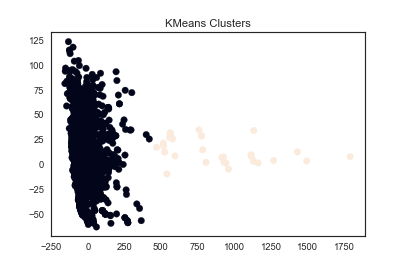

The threshold that you have to set in config file is: 599


In [92]:
############################################################################
#                      Calibration System: Main Function                   #
############################################################################
print("Welcome to the calibration phase of EMPhASIS.")
print("Please, remember that calibration is necessary just once, before the first utilizaiton on"
      +" a new user.")
df = calibration_sample_acquisition()
weights, pca_d, df = calibration_pca_weigths(df)
print("PCA weights you have to set in the config file are: ")
print("SVI weight: "+str(weights[0][0]))
print("dLFHF weight: "+str(weights[0][1]))
print("mHR weight: "+str(weights[0][2]))
print("mRR weight: "+str(weights[0][3]))
print("nHF weight: "+str(weights[0][4]))
print("nLF weight: "+str(weights[0][5]))
threshold, predicted = get_threshold(weights, pca_d, df)
print("The threshold that you have to set in config file is: "+str(threshold))
